In [15]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [16]:
dataset=r'drive/My Drive/Mask Dataset'
imagePaths=list(paths.list_images(dataset))

In [17]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [63]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

In [64]:
labelBinarizer = LabelBinarizer()
binarizedLabels = labelBinarizer.fit_transform(labels)
binarizedLabels = to_categorical(binarizedLabels)

In [65]:
train_X,test_X,train_Y,test_Y = train_test_split(data, binarizedLabels, test_size=0.20,stratify=labels,random_state=10)

In [66]:
imageGenrator=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [42]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [43]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [44]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [45]:
for layer in baseModel.layers:
    layer.trainable=False

In [46]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [67]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    imageGenrator.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)


model.save(r'drive/My Drive/')

Epoch 1/20
92/92 [==============================] - 17s 180ms/step - loss: 0.2045 - accuracy: 0.9106 - val_loss: 0.0141 - val_accuracy: 0.9964
Epoch 2/20
92/92 [==============================] - 14s 149ms/step - loss: 0.0619 - accuracy: 0.9799
Epoch 3/20
92/92 [==============================] - 14s 148ms/step - loss: 0.0772 - accuracy: 0.9717
Epoch 4/20
92/92 [==============================] - 14s 150ms/step - loss: 0.0690 - accuracy: 0.9754
Epoch 5/20
92/92 [==============================] - 14s 152ms/step - loss: 0.0467 - accuracy: 0.9818
Epoch 6/20
92/92 [==============================] - 14s 150ms/step - loss: 0.0320 - accuracy: 0.9872
Epoch 7/20
92/92 [==============================] - 14s 150ms/step - loss: 0.0273 - accuracy: 0.9900
Epoch 8/20
92/92 [==============================] - 14s 150ms/step - loss: 0.0735 - accuracy: 0.9790
Epoch 9/20
92/92 [==============================] - 14s 151ms/step - loss: 0.0613 - accuracy: 0.9799
Epoch 10/20
92/92 [==============================

In [69]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=labelBinarizer.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       139
without_mask       0.99      1.00      1.00       139

    accuracy                           1.00       278
   macro avg       1.00      1.00      1.00       278
weighted avg       1.00      1.00      1.00       278



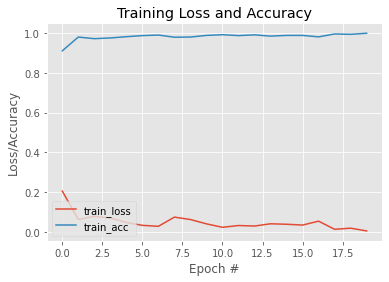

In [85]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [82]:
H.history

{'accuracy': [0.9105839133262634,
  0.9799270033836365,
  0.9717153310775757,
  0.9753649830818176,
  0.9817517995834351,
  0.9872262477874756,
  0.9899635314941406,
  0.9790145754814148,
  0.9799270033836365,
  0.9881386756896973,
  0.9917883276939392,
  0.9872262477874756,
  0.9909420013427734,
  0.9844890236854553,
  0.9882246255874634,
  0.9881386756896973,
  0.9808394312858582,
  0.9954379796981812,
  0.9936131238937378,
  0.9990875720977783],
 'loss': [0.2044776827096939,
  0.06189033016562462,
  0.07722505182027817,
  0.06897240877151489,
  0.04666060209274292,
  0.031959742307662964,
  0.027300698682665825,
  0.07349918782711029,
  0.061276618391275406,
  0.03958459571003914,
  0.02221432700753212,
  0.031192827969789505,
  0.028640855103731155,
  0.03991664946079254,
  0.03755289688706398,
  0.033456843346357346,
  0.05312959477305412,
  0.01214204728603363,
  0.01779327355325222,
  0.004014978185296059],
 'val_accuracy': [0.9964028596878052],
 'val_loss': [0.01411079522222280